# COGS 108 - Final Project 

# Overview

Access to parks and recreation is becoming more and more important to public health as cities such as San Diego face another wave of stay at home orders in the wake of the growing COVID-19 pandemic. Parks not only provide a space for people to escape their homes and perform activites to boost their physcial and/or mental health, but they can also promote environmental sustainability amongst community members through land conservation, landfill waste reduction, and other various practices and programs to help engage the community, yet there are some communities that do not offer the the same access to parks to their community members as other communities do, which could possibly have an effect on the overall health of its members. To dig deeper into this topic, I wanted to see if having a high access to park percentage was correlated with having a high CalEviroScreen 2.0 score as a measure of health, but after analyzing the data surrounding this particular subject, I was unable to find a correlation between CES 2.0 scores and access to parks percent estimates. 

# Name & GitHub

- Name: Justin Sung
- GitHub Username: jjs050

# Research Question

Is there a correlation between Access to Park estimates and CES 2.0 Scores for census tracts within San Diego? 

## Background and Prior Work

In order to better understand this topic, I first had to inspect CES 2.0 scores of census tracts that were only specific to San Diego to understand what variables were assesed when the CalEnviroScreening tool is deciding on a score for a partiuclar census tract, and what was the purpose of having such a score be assigned to a particular census tract. According to the documentation provided by the OEHHA, the CalEnviroScreen model takes into consideration a limited set of indicators that either fall under Pollution Burden or Population Characteristics, such as drinking water and unemployment rate (1). A scoring system is then used to weigh the indiciators and then afterwards the model takes the sum of the indicators of Pollution Burden and multiplies them with the sum of the indiciators of Population Characteristics to derive a CalEnviroScreen Score (1). Each component can only get a maximum score of 10, making the CalEnviroScreen Score for a given census tract a maximum of 100 (1). With this scoring system, the state of California is able to prioritize what regions should receive grants or funding for sustainable development or more stricter environment laws. (2)

On the other hand, I also had to better understand how the estimates for access to parks were measured. It turns out that access to parks was measured as a percent of the population within 1/2 a mile of a park, beach, open space or coastline for California (3). Access to parks as a result serves as one of many indicators used by the Office of Health Equity to assess community health through the Healthy Communities Data and Indicators Project, or HCI (3). Census tracts were also used in this dataset, so I made sure to limit the data to only include census tracts that were located within San Diego. Both census tracts from the CES 2.0 dataset and the HCI access to parks dataset use data from the 2010 census.   

Prior work on measuring how accessibility to parks relates to health has been done through measured indicators such as the Healthy Places Index, an index published by the Public Health Alliance of Southern California to measure health disadvantage of California census tracts. In this index, park access was identified to be a positive indicator of health that was later included in the calculation of the index, as it had a high enough correlation with health to be included in the HPI's model scoring (4). 

References (include links):
- 1) https://data.ca.gov/dataset/calenviroscreen-2-0
- 2) https://oehha.ca.gov/calenviroscreen/calenviroscreen-faqs#:~:text=How%20is%20CalEnviroScreen%20being%20used,opportunities%20for%20sustainable%20economic%20development.
- 3) https://data.ca.gov/dataset/park-beach-open-space-or-coastline-access
- 4) https://healthyplacesindex.org/wp-content/uploads/2018/05/HPI2Documentation2018-05-30-FINAL.pdf

# Hypothesis


I hypothesize that census tracts that have a higher access to park estimates will have higher CES scores, and parks with lower access to park estimates will have lower CES scores. Census tracts that have higher access to park percentages are more likely to have more parks avaliable to the public, which means less roads for cars to create traffic pollution and more open land to reduce air pollution. Thus this will increase the CES score of a paticular census tract. On the other hand, census tracts with less access to park estimates are more likely to have fewer parks nearby that people can access, which means less open land to reduce air pollution and therefore reducing the CES score of that region. 

# Dataset(s)

Dataset 1) 
- Dataset Name: California Park, Beach, Open Space, or Coastline Access Data
- Link to datset: https://data.ca.gov/dataset/park-beach-open-space-or-coastline-access
- Number of observations: 543187

Dataset 2) 
- Datset Name: California Environmental Health Screening Data
- Link to dataset: https://data.ca.gov/dataset/calenviroscreen-2-0
- Number of observations: 8035

The first dataset contains information about the percentage of people of a given population who have access to a park within a half a mile radius. The given population data is based on census tracts, regions, county subdivisions, cities, and towns within California.   

The second dataset contains information about CalEnviroScreen scores of census tracts in California, as well as the measurements of the indicators that went into determining that said census tract's CES score. 

To combine the two datasets, I plant to merge the two based on if both have the same census tract number to show the relationship between access to parks and CES scores. I also plant to keep other indicators of CES scores like Unemployment, Poverty, Traffic, and Groundwater Threats to see if those variables have a much stronger impact on CES scoring. 

# Setup

In [1]:
# import libraries for project 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm
import scipy.stats as stats

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# The seaborn library makes plots look nicer
sns.set()
sns.set_context('talk')

# Don't display too many rows/cols of DataFrames
pd.options.display.max_rows = 7
pd.options.display.max_columns = 10

# Round decimals when displaying DataFrames
pd.set_option('precision', 2)
pd.set_option('display.float_format', lambda x: '%.1f' % x)

# Data Cleaning

Load data and remove unecessary columns from merged dataset

In [2]:
#loads the datasets used for analysis
health_score = pd.read_csv('../data/calenviroscreen-final-report.csv')
hci_access  = pd.read_excel('../data/hci_accesstoparks_469_ca_re_co_cd_pl_ct-7-3-2017-ada.xlsx', sheet_name="Data")

In [3]:
# restrict CES health scores to only San Diego County
health_score = health_score[health_score['California County'] == 'San Diego']
# remove unecessary columns
health_score = health_score.drop(columns=['Click for interactive map', 'Hyperlink', 'Location 1'])

In [4]:
# Restrict HCI access to park data to only census tracts within San Diego (remove census tracts with population 0)
hci_access = hci_access.drop(columns=['ind_id', 'ind_definition', 'reportyear', 'region_code' ])
hci_access= hci_access[(hci_access.strata_one_code == 1)&(hci_access.geotype == "CT") & (hci_access.county_name == "San Diego") & (hci_access.race_eth_code == 9) & (hci_access.denominator > 0)]
hci_access = hci_access[['geotypevalue', 'estimate']]

In [5]:
# merge datasets based on census tract 
park_data = hci_access.merge(health_score, left_on="geotypevalue", right_on="Census Tract")

In [6]:
# cleanup merged dataset by removing NaN values and census tracts with 0 total population 
park_data = park_data[['Census Tract', 'CES 2.0 Score', 'estimate', 'Total Population', 'Poverty', 'Unemployment', 'Traffic', 'Groundwater Threats']]
park_data.dropna(subset=['Census Tract','Total Population','CES 2.0 Score','estimate'], inplace=True)
park_data = park_data[park_data['Total Population'] > 0]
park_data.duplicated(subset=['Census Tract']).any()

False

# Data Analysis & Results

To start off the data analysis, I wanted to see how the data was by looking at average values and what the data looked like in general

In [7]:
desc = park_data.describe()
print(desc)

       Census Tract  CES 2.0 Score  estimate  Total Population  Poverty  \
count         623.0          623.0     623.0             623.0    617.0   
mean   6073012593.2           18.5      73.8            4962.3     32.4   
std          6036.9            9.3      36.0            2566.4     18.4   
...             ...            ...       ...               ...      ...   
50%    6073013411.0           17.2      95.6            4635.0     28.6   
75%    6073017701.5           23.2     100.0            5898.0     44.3   
max    6073022100.0           59.9     100.0           37452.0     84.9   

       Unemployment  Traffic  Groundwater Threats  
count         618.0    623.0                623.0  
mean            9.9   1593.9                 20.8  
std             4.4   2119.7                 48.9  
...             ...      ...                  ...  
50%             9.2   1046.0                  8.0  
75%            12.7   2240.9                 21.9  
max            28.5  43561.8       

In [44]:
On average, census tracts in San Diego had a CES score of 18.5 and a access to park percentage of 73.8 percent. 

SyntaxError: invalid syntax (<ipython-input-44-9b9b4470ba48>, line 1)

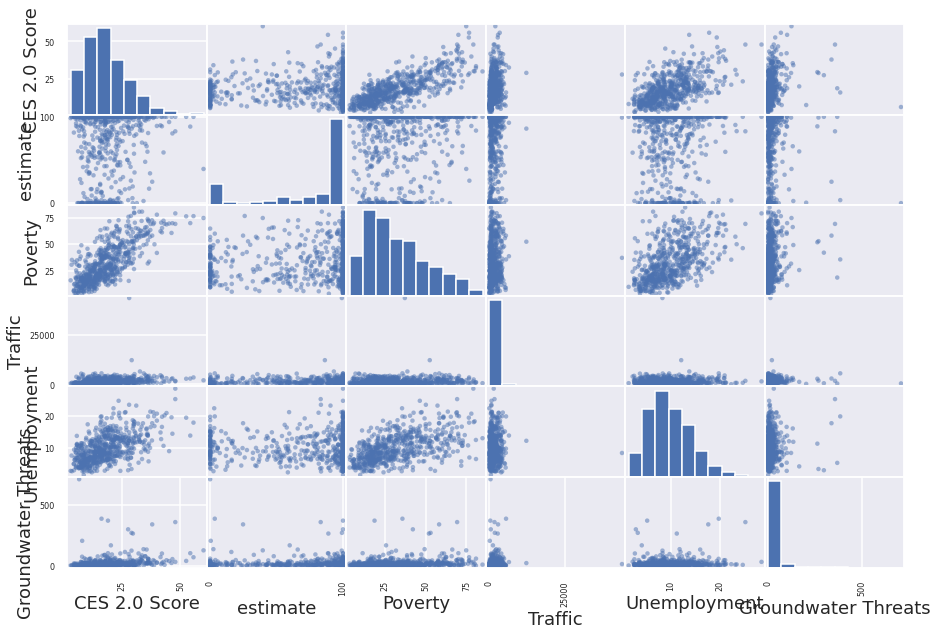

In [8]:
pd.plotting.scatter_matrix(park_data[['CES 2.0 Score', 'estimate', 'Poverty', 'Traffic', 'Unemployment', 'Groundwater Threats']], 
                           figsize=(15, 10));

Figure 1: Scatter plot matrix of columns in park_data

I noticed that for census tracts in San Diego, there was a noticeable patter of a large majority of census tracts that had 100 percent access to park estimates, and a smaller outlier of census tracts that had a zero percent access to park estimate. 

Text(0, 0.5, 'Frequency')

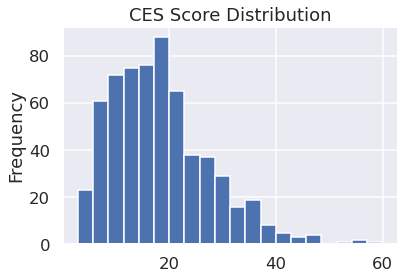

In [11]:
ax = park_data['CES 2.0 Score'].plot.hist(bins = 20)
ax.set_title('CES Score Distribution')
ax.set_ylabel('Frequency')

Figure 2: CES Scores are ranged between 0 to 100. A majority of census tracts in San Diego have a score below 40. 

Text(0, 0.5, 'Frequency')

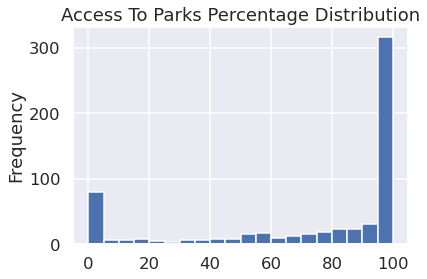

In [12]:
estimate_plot = park_data['estimate'].plot.hist(bins = 20)
estimate_plot.set_title('Access To Parks Percentage Distribution')
estimate_plot.set_ylabel('Frequency')

Figure 3: Access to Park percentages range from 0 to 100. A large majority of census tracts have a 100 percent access to park estimate. 

Text(0.5, 0, 'Access to Park Percentage')

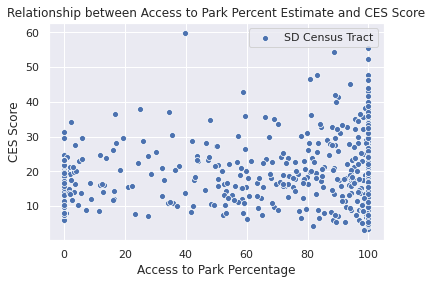

In [21]:
sns.set()
relation = sns.scatterplot(x = park_data['estimate'], y = park_data['CES 2.0 Score'], data = park_data, label='SD Census Tract')
relation.set_title('Relationship between Access to Park Percent Estimate and CES Score') 
relation.set_ylabel('CES Score')
relation.set_xlabel('Access to Park Percentage')


Figure 4: Looking at this data, it is not very clear if there is a relationship between access to park percentage estimates and CES scores

To better understand if there exists a correlationship between these two variables, I first checked the correaltionship of every variable in the dataset 

In [22]:
corrs = park_data.corr(method='pearson')
print(corrs)

                     Census Tract  CES 2.0 Score  estimate  Total Population  \
Census Tract                  1.0           -0.2      -0.4               0.1   
CES 2.0 Score                -0.2            1.0       0.0              -0.0   
estimate                     -0.4            0.0       1.0              -0.1   
...                           ...            ...       ...               ...   
Unemployment                 -0.1            0.6      -0.0               0.0   
Traffic                      -0.1            0.2       0.1               0.0   
Groundwater Threats          -0.1            0.2      -0.1               0.2   

                     Poverty  Unemployment  Traffic  Groundwater Threats  
Census Tract            -0.2          -0.1     -0.1                 -0.1  
CES 2.0 Score            0.8           0.6      0.2                  0.2  
estimate                 0.1          -0.0      0.1                 -0.1  
...                      ...           ...      ...        

Looking at this summary, there did not seem to be a strong relationship between the access to park estimates and CES scores with their r value being less than 0.1. However, to make sure that this was the case I decided to perform linear regression to see if I could generate a best fit line to identify a relationship between access to park estimates and CES scores. 

# Linear Regression between Access to Park and CES Score

Before performing linear regression however, need to check that total population is not a confounding variable. 

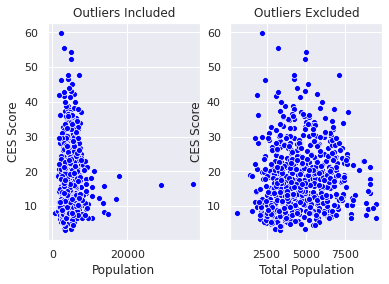

In [24]:
f,ax = plt.subplots(1, 2)


sns.scatterplot(x='Total Population', y='CES 2.0 Score', data=park_data, color='blue', ax=ax[0])
ax[0].set(xlabel='Population', 
          ylabel='CES Score',
          title='Outliers Included')

pop_q1 = park_data['Total Population'].quantile(0.25)
pop_q3 = park_data['Total Population'].quantile(0.75)
pop_iqr = pop_q3 - pop_q1
sns.scatterplot(x='Total Population', y='CES 2.0 Score', 
                data=park_data[park_data['Total Population'].between((pop_q1 - 1.5 * pop_iqr), (pop_q3 + 1.5 * pop_iqr))], 
                color='blue', ax=ax[1])
_ = ax[1].set(xlabel='Total Population',
              ylabel='CES Score',
              title='Outliers Excluded')

Figure 5: Data comparison of Total Population with and without outliers. 

Looking at the data above, there does not seem to be a correlation between Total population and CES scores, so we can continue on with our linear regression

In [25]:
park_data.rename(columns={'CES 2.0 Score':'CES_score'}, inplace=True)

outcome, predictors = patsy.dmatrices('estimate ~ CES_score', park_data)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               estimate   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.122
Date:                Wed, 16 Dec 2020   Prob (F-statistic):              0.290
Time:                        19:08:04   Log-Likelihood:                -3115.5
No. Observations:                 623   AIC:                             6235.
Df Residuals:                     621   BIC:                             6244.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     70.7448      3.200     22.109      0.0

Text(0.5, 0, 'Access to Park Percentage')

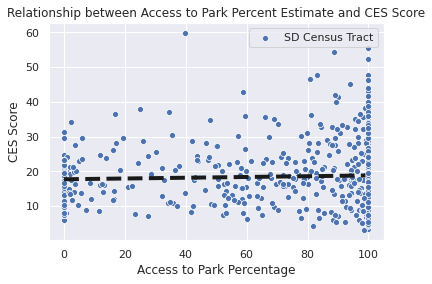

In [26]:
# plot scatterplot
sns.scatterplot(x = park_data['estimate'], y = park_data['CES_score'], data = park_data, label='SD Census Tract')

# create model fit line 
xs = np.arange(park_data['estimate'].min(), park_data['estimate'].max())
ys = 0.0110 * xs + 17.6750
plt.plot(xs, ys, '--k', linewidth=4, label='Model')

plt.title('Relationship between Access to Park Percent Estimate and CES Score') 
plt.ylabel('CES Score')
plt.xlabel('Access to Park Percentage')

Figure 6: The line generated by the linear regression model seems to support our inital discovery that there does not exist a relationship between access to park estimates and CES scores

# Ethics & Privacy

For this project, the dataset provided to us was given, so I was granted permission to use these two datasets in my analysis. The sources of these two datasets are also very clear, as they both come from the California state government's open data website, https://data.ca.gov. Both the CES Score dataset and the HCI dataset contained information about census tracts which were taken from the 2010 US census, which has information that is public but also quite outdated, as it has been ten years since that data was recorded. However, it can be said that the data generated from both datasets was collected objectively by both the US Census Bureau and the state government of California, which removes the concern of collection bias. 

With regards to privacy, while the census tracts overall do a good job at keeping information about people in a specific census tract private, there still must be some consideration to be made for census tracts that only have ten or so people in them. However, the only information used in this dataset was access to park estimates, CES scores, and population indicators like poverty and unemployment, which are unable to be used to identify a specific individual. 

In addition, the results of this analysis could unintentionally affect the way parks accesss is viewed. Considering that there seems to be no relationship between park access and enviornmental burden, this could sway some to believe that parks do not have an intrinsic value. However, the purpose of this research project is to understand what is the relationship between access to parks and health, and in no way does it imply that parks do not have any intrinsic value to the public's health and wellbeing. 

# Conclusion & Discussion

After performing some data analysis on the given dataset, it was concluded that there was no relationship between access to parks and CES scores per census tract, thus rejecting my hypothesis. This however does seem to make sense as park access is not included as an indicator in CES scoring. Plus, more park access does not necessarily mean that there are more parks within a census tract avaliable to the public, as seen with the huge outlier of census tracts with 100 percent acess to park estimates but varying CSE scores. More access to parks could also mean that there is more housing avaliable around a given park, which could have a negative effect on the environment such as how much more waste is produced from each household and affect the CES scoring negatively. 

However, some of the data in this analysis could have affected the conclusion that was just drawn. The large outlier of census tracts with 100 percent park access with the smaller but still noticable outlier of census tracts with 0 percent park access may have possibly swayed the data in a way that removed any correlation between park access and CES scores. 

In conclusion, it would seem that CES scores might not have been an accurate measurement of health impact by parks. Rather than using CES scores as a measure of impact on health parks access have on the community, a much better index of measurement would be one like the Healthy Places Index highlighted in the Prior work section, which does include access to parks as an indicator of health. 